# LLMs Build from scratch
***
## 🧠 GPT2 From Scratch — 手写一个可训练的 GPT 模型

本 Notebook 展示了如何 **从零开始实现一个完整的 GPT 模型**，包括：

- Token Embedding, Position Embedding  
- Multi-Head Attention（含 Masked Self-Attention）
- FeedForward、Residual、LayerNorm
- Transformer Decoder Block
- GPT 模型封装
- generate() 自回归生成
- 自定义 JSONL-Token-Block Dataset 构建
- 模型训练（optimizer + scheduler）
- Loss 可视化
- 推理 demo


***

# 1. Load Packages

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from dataclasses import dataclass

torch.manual_seed(1024) # 设置 PyTorch 中随机数生成器的种子（seed），从而保证代码每次运行时的随机结果一致

In [2]:
print("torch cuda 是否可用")
torch.cuda.is_available()

torch cuda 是否可用


True

In [3]:
print("可用GPU数量")
torch.cuda.device_count()

可用GPU数量


2

# 2. Define GPT Related Hyper-Parameters

In [4]:
@dataclass
class GPTConfig:
    block_size: int = 512 # 文本的最大长度 Max Seq
    batch_size: int = 12
    n_layer: int = 12
    n_head: int = 12 # 头的数量
    n_embd: int = 768 # hidden_dim or hidden_size
    hidden_dim: int = n_embd
    dropout: float = 0.1
    head_size: int = n_embd // n_head # 64
    # vocab size
    # GPT2 官方的tokenizer
    vocab_size: int = 50257

#### 装饰器 
`@dataclass` 是 Python 的 装饰器（decorator）。
就是在定义类 GPTConfig 时，让 dataclass 自动帮你生成一些常用方法，比如：
- `__init__()`
- `__repr__()`
- `__eq__()`
- 默认值处理

例如：
```python
@dataclass
class GPTConfig:
    block_size: int = 512
```
相当于：
```python
class GPTConfig:
    def __init__(self, block_size: int = 512):
        self.block_size = block_size
```

#### 整数除法
`n_embd // n_head` 是整数除法，向下取整

#### GPT2 Vocab Size
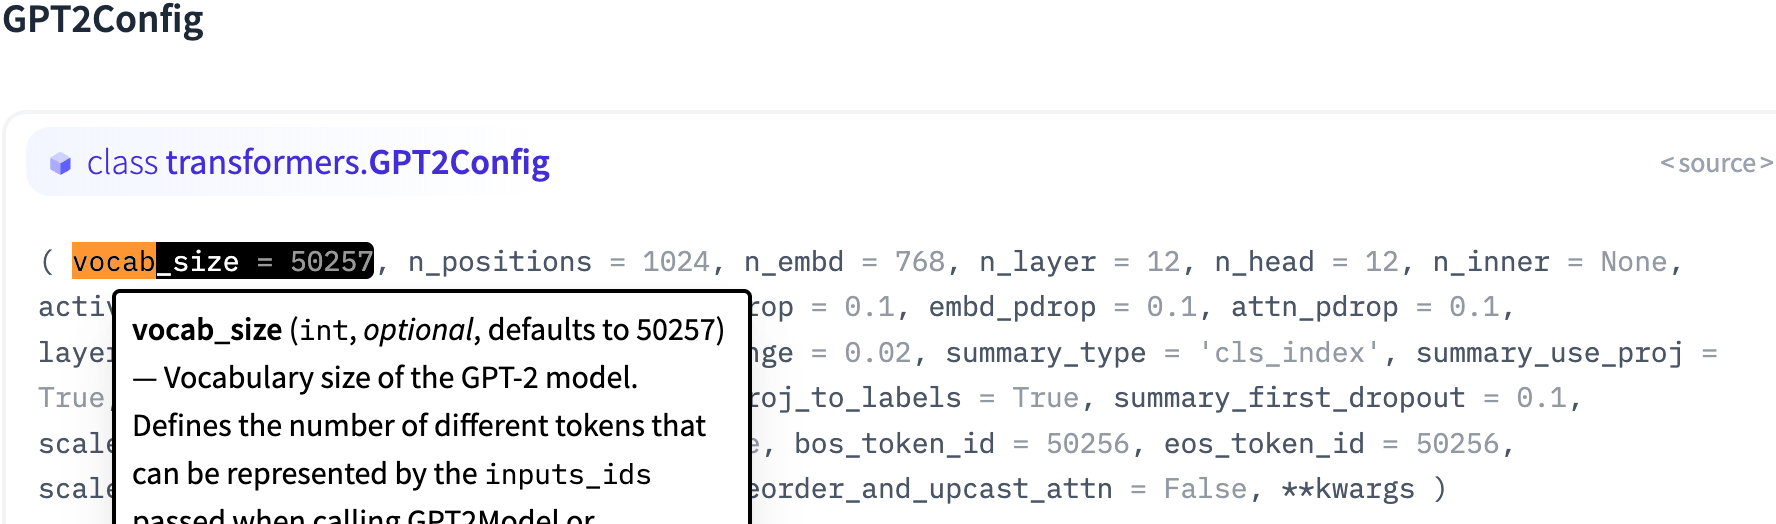

🤖: [GPT-2 Hugging Face](https://huggingface.co/docs/transformers/en/model_doc/gpt2)

# 3. Define Structure of GPT

In [13]:
# 1. Single Head Attention
class SingleHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.key = nn.Linear(config.hidden_dim, config.head_size) # 这里只定义了一个头，实际是多头在hidden dim 这个维度上拼接
        self.query = nn.Linear(config.hidden_dim, config.head_size)
        self.value = nn.Linear(config.hidden_dim, config.head_size)
        
        self.head_size = config.head_size 
        
        # 写Attention的新的方法，attention_mask通过 register_buffer注册
        # 因为Mask之后不用计算梯度
        # 用来防止GPT看到未来的token
        self.register_buffer(
            "attention_mask",
            torch.tril(
                torch.ones(config.block_size, config.block_size)
            )
        )
        
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        batch_size, seq_len, hidden_len = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        weight = q @ k.transpose(-2, -1) # @ 就是 torch.matmul的简单写法
        
        # head_size 就是隐藏向量 hidden_size，T是Seq Length（padding之后的）
        # q: (B, H, T, head_size)
        # k.transpose(-2, -1): (B, H, head_size, T) 
        
        weight = weight.masked_fill(
            self.attention_mask[:seq_len, :seq_len] == 0, # 实际上的seq len可能没有block size来的大
            float('-inf') # 将参数变为负无穷防止影响梯度计算
        )
        
        # 要注意计算除以根号dk
        weight = F.softmax(weight, dim = -1) / math.sqrt(self.head_size)
        
        # dropout 要放到weight后面
        weight = self.dropout(weight)
        
        out = weight @ v # (T, head_size)
        return out
        
# 2. multi head attention
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(config)
                for _ in range(config.n_head)
            ]
        )
        self.proj = nn.Linear(config.hidden_dim, config.hidden_dim)
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        # 单个输出是 (T, head_size)
        # (B, T, head_size) 在最后的一个维度进行拼接，还原回 (B, T, hidden_dim)
        output = torch.cat(
            [h(x) for h in self.heads],
            dim = -1
        )
        output = self.proj(output)
        output = self.dropout(output)
        return output
        
# 3. Feed Forward
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.hidden_dim, 4 * config.hidden_dim), # 升维度
            nn.GELU(),
            nn.Linear(4 * config.hidden_dim, config.hidden_dim),
            nn.Dropout(config.dropout)
        )
        
    def forward(self, x):
        return self.net(x)
        
# 4. block
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.att = MultiHeadAttention(config)
        self.ffn = FeedForward(config)
        self.ln1 = nn.LayerNorm(config.hidden_dim) # 有两个不同的layer norm
        self.ln2 = nn.LayerNorm(config.hidden_dim)
        
    def forward(self, x):
        x = x + self.att(self.ln1(x)) # 注意使用残差完成
        x = x + self.ffn(self.ln2(x))
        return x
    
# 5. GPT
# token embedding, position, nor,, mlp
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        # (embedding, position, norm, mlp, block)
        # position embedding: 从 0, 1, xxx embedding ---升级到---> rope
        # norm: 从 layer norm ---升级到---> rms norm
        # mlp: 从 mlp ---升级到---> swiglu
        # multi head attention ---升级到---> gqa
        self.config = config # 记录配置
        
        self.token_embedding_table = nn.Embedding(config.vocab_size, config.n_embd) # 从词表映射到 hidden layer
        self.position_embedding_table = nn.Embedding(config.block_size, config.n_embd) # 可训练的位置编码
        self.blocks = nn.Sequential(
            *[Block(config) for _ in range(config.n_layer)] # 星号解包参数传给sequential
        )
        
        self.ln_final = nn.LayerNorm(config.n_embd) # 在隐藏层维度做norm
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias = False)
        
        # 现在的SLM模型，互用tie weight来减少参数
        # 非常重要
        # self.token_embedding_table.weight = self.lm_head.weight
        # Linear (4 -> 8), weight 实际上是 (8 * 4) 而不是 4 * 8 因为有转置关系
        self.lm_head.weight = self.token_embedding_table.weight
    
    # 因为这里面主要都是Linear以及Embedding，所以对参数要进行初始化
    def _init_weight(self, module):
        if isinstance(module, nn.Linear):
            # 初始化为正态分布
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        # idx       输入是 token ids (batch, seq_len)
        # targets   是目标 token ids (batch, seq_len)
        # shape 要一样
        batch, seq_len = idx.size() # (batch, seq_len)
        
        # model beigin
        token_emb = self.token_embedding_table(idx) # (batch, seq_len, n_embd)
        pos_emb = self.position_embedding_table(
            # 要确保 位置编码和输入的 idx 在同一个设备上
            torch.arange(seq_len, device=idx.device)
        )
        
        x = token_emb + pos_emb     # (batch, seq_len, n_embd)
        x = self.blocks(x)           # (batch, seq_len, n_embd)
        x = self.ln_final(x)    
        logits = self.lm_head(x)    # (batch, seq_len, vocab_size)
        
        if targets is None:
            loss = None             # 推理 inference
        else:
            batch, seq_len, vocab_size = logits.size()
            logits = logits.view(batch * seq_len, vocab_size)
            targets = targets.view(batch * seq_len)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx shape (batch, seq_len)
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond) # 传入模型
            
            # logits: (batch, seq_len, vocab_size)
            logits = logits[:, -1, :] # 只取最后一个token
            probs = F.softmax(logits, dim=-1) #  对vocab取softmax
            
            # 随机采样
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim = 1) # (batch, seq_len+1)
            
        return idx 
        
        

### generate函数
```python
idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
```
你输入了 700 个 token，但 block_size=512，那么就只取最后 512 个 token。

🧠 那为什么不用 513？为什么只取最后一个？因为自回归模型（GPT）设计成：

每次只能预测“下一个 token”，而不是把整个序列扩展后再输出。

如：
logits for x1  
logits for x2  
logits for x3  
...  
logits for x512  

#### Attention Mask
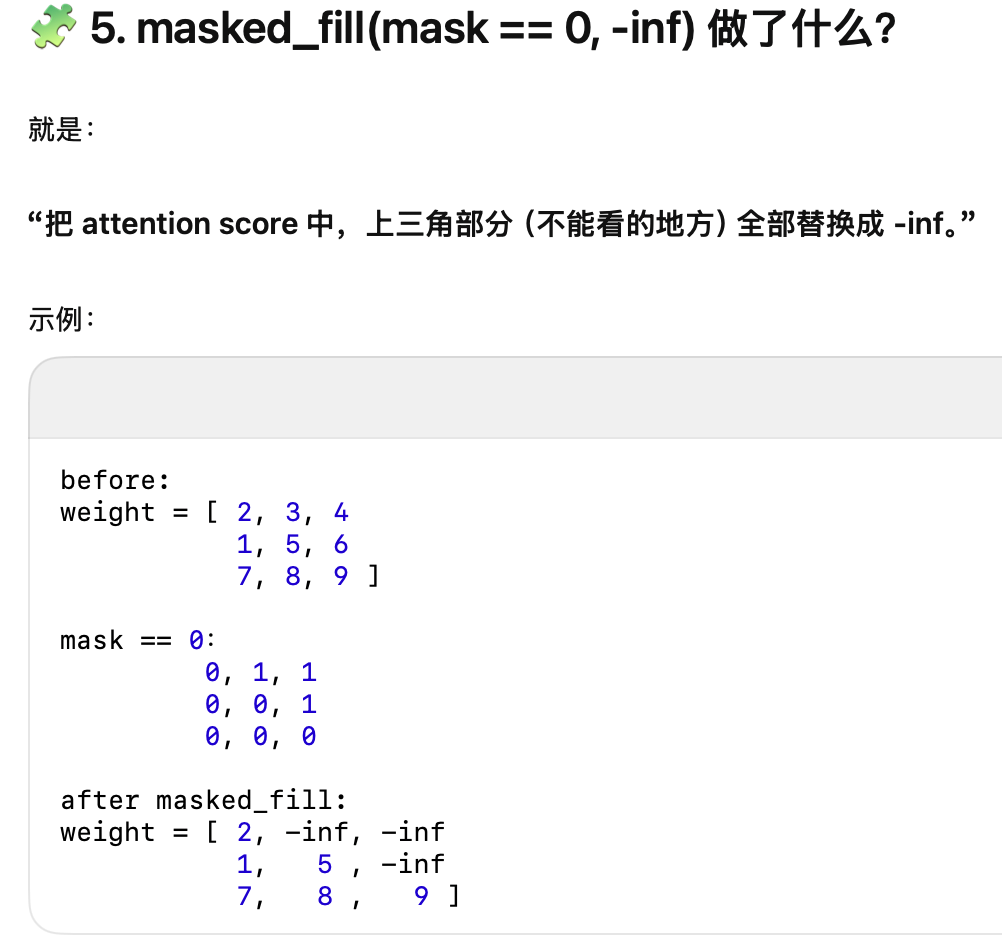

# 4. Construct Dataset
构建并了解模型的输入

In [6]:
import tiktoken

In [7]:
class MyDataset(Dataset):
    def __init__(self, path, block_size = 512):
        self.enc = tiktoken.get_encoding("gpt2")
        self.block_size = block_size    # pos最大长度
        
        self.encoded_data = []
        # 特殊符号区分不同的训练文本
        # <|endoftext|> --> [50256]
        # 获得特殊字符（结束符号）在gpt2中的编码
        # 如果遇到 <|endoftext|>，把它当成一个特殊 token，而不是普通字符，并返回其编码
        # 用来分隔不同的训练样本  
        self.eos_token = self.enc.encode(
            "<|endoftext|>",
            allowed_special = {"<|endoftext|>"}
        )[0]
        
        import json
        self.max_lines = 20000 # 只读1000行
        raw_data = []
        
        with open(path, 'r') as f:  # 逐行读取，否则内存爆掉
            for i, line in enumerate(f):
                if i >= self.max_lines: # 如果全部读取，则把这部分给注释掉
                    break
                try:
                    text = json.loads(line.strip())['text'] # 去掉换行符并读取text部分的内容
                    raw_data.append(text)
                except Exception as e:  # 捕获所有错误
                    continue
        
        # 在实际的训练中，是将所有的文本数据都放成一行
        full_encode = []
        for text in raw_data:
            encoded_text = self.enc.encode(text) # list
            full_encode.extend(encoded_text + [self.eos_token])
        
        # block_size 是 512
        # 长 -> 短 512
        for i in range(0, len(full_encode), self.block_size):
            chunk = full_encode[i:i+self.block_size + 1] # 512 省略shift操作 增一个token变为513
            if len(chunk) < self.block_size + 1:
                chunk = chunk + [self.eos_token] * (self.block_size + 1 - len(chunk)) # 不足时，使用特殊符号补全
            self.encoded_data.append(chunk) # 每一行长度为513
            
    def __len__(self):
        return len(self.encoded_data) # 处理后之后的数据样本数
    
    def __getitem__(self, idx):
        """数据处理的时候完成tensor化"""
        chunk = self.encoded_data[idx]
        x = torch.tensor(chunk[:-1], dtype=torch.long) # 输入前512
        y = torch.tensor(chunk[1:], dtype=torch.long)  # 输出后512
        return x, y
    
    def encode(self, text):
        """将文本编码为 token ids"""
        return self.enc.encode(text)
    
    def decode(self, ids):
        """将ids编码为文本"""
        return self.enc.decode(ids)
                
                

`strip( )` 会去掉：
- 换行符 \n
- 空格
- 制表符 \t

`self.block_size + 1`的原因：
- input:  block_size 个 token
- target: block_size 个 token
在这里，分割的时候分割为513，直接预留多一个token给target进行预测

##### `dataset`和`dataloader`

DataLoader 的父类：

内部实现是 C++ 风格，并没有从 Dataset 派生。

所以：

Dataset 不是 DataLoader 的父类，两者没有继承关系。
DataLoader 只是使用 Dataset，不是覆盖它。

> Dataset 负责“存数据”，DataLoader 负责“取数据、分 batch、打乱顺序、多线程加载”。

就像 Dataset 是一本书，DataLoader 是个帮你一页一页送过来的服务员。

# 5. Running GPT Train

In [8]:
model = GPT(GPTConfig())
device = "cuda" if torch.cuda.is_available() else 'cpu'
model = model.to(device)


# 打印模型的参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params / 1e6 } M") 

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 1000) # 设置cosine学习率

Total parameters: 124.046592 M


In [9]:
# train data
data_path = "/home/liangshurui/build_GPT/data/mobvoi_seq_monkey_general_open_corpus.jsonl"
train_dataset = MyDataset(data_path)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])

train_loader = DataLoader(train_dataset, batch_size = 12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)


# 打印数量
print(f"Total dataset size: {len(train_dataset) + len(val_dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size:   {len(val_dataset)}")

Total dataset size: 71513
Train dataset size: 64362
Val dataset size:   7151


In [10]:
# 训练循环
def train(model, optimizer, scheduler, train_loader, val_loader, device):
    model.train() # 在eval的时候会将drpout这些东西给去除掉，在train的时候要保留
    total_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        # 将数据放到设备上
        x, y = x.to(device), y.to(device)
        
        # 前向传播
        logits, loss = model(x, targets=y)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 调整学习率
        scheduler.step()
        
        # 统计loss
        total_loss += loss.item()
        step_losses.append(loss.item()) # step的loss
        
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            
    return total_loss

def eval(model, val_loader, device):
    """验证"""
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, loss = model(x, targets = y)
            
    return val_loss

train_losses = []
val_losses = []
step_losses = [] 

for epoch in range(2):
    train_loss = train(model, optimizer, scheduler, train_loader, val_loader, device)
    val_loss = eval(model, val_loader, device)
    
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f'Epoch: {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    # 保存模型
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': avg_val_loss,
    }
    
    # 保存每个epoch的模型
    torch.save(checkpoint, f'checkpoints/model_epoch_{epoch}.pt')
        

Epoch: 0, Batch: 0, Loss: 485.0361
Epoch: 0, Batch: 100, Loss: 10.2257
Epoch: 0, Batch: 200, Loss: 6.4590
Epoch: 0, Batch: 300, Loss: 5.9289
Epoch: 0, Batch: 400, Loss: 5.2177
Epoch: 0, Batch: 500, Loss: 5.2954
Epoch: 0, Batch: 600, Loss: 5.3920
Epoch: 0, Batch: 700, Loss: 5.0806
Epoch: 0, Batch: 800, Loss: 4.8993
Epoch: 0, Batch: 900, Loss: 4.8763
Epoch: 0, Batch: 1000, Loss: 5.0575
Epoch: 0, Batch: 1100, Loss: 4.9033
Epoch: 0, Batch: 1200, Loss: 4.9269
Epoch: 0, Batch: 1300, Loss: 4.9626
Epoch: 0, Batch: 1400, Loss: 5.0030
Epoch: 0, Batch: 1500, Loss: 5.3432
Epoch: 0, Batch: 1600, Loss: 4.9401
Epoch: 0, Batch: 1700, Loss: 5.5569
Epoch: 0, Batch: 1800, Loss: 4.8317
Epoch: 0, Batch: 1900, Loss: 4.9264
Epoch: 0, Batch: 2000, Loss: 4.7943
Epoch: 0, Batch: 2100, Loss: 4.4451
Epoch: 0, Batch: 2200, Loss: 4.4008
Epoch: 0, Batch: 2300, Loss: 4.1897
Epoch: 0, Batch: 2400, Loss: 4.0900
Epoch: 0, Batch: 2500, Loss: 4.1359
Epoch: 0, Batch: 2600, Loss: 3.9585
Epoch: 0, Batch: 2700, Loss: 3.9272
E

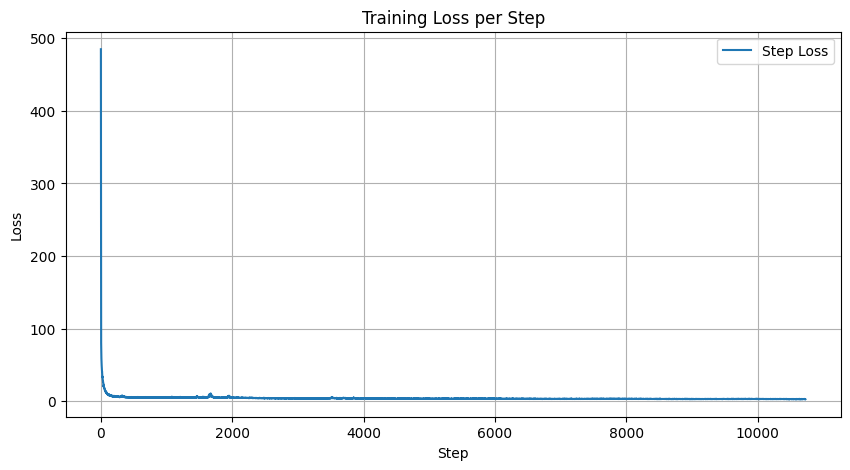

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(step_losses, label="Step Loss") # 设置不透明度 alpha=0.4

# # 可选：做一个平滑版本（滑动平均），看起来更直观
# import numpy as np
# window = 100  # 滑动窗口大小
# if len(step_losses) > window:
#     smooth = np.convolve(step_losses, np.ones(window)/window, mode='valid')
#     plt.plot(range(window-1, window-1+len(smooth)), smooth, label=f"Smoothed (window={window})")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss per Step")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
import torch

# 0. 加载模型
config = GPTConfig()   # 和训练时用的一样
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GPT(config).to(device)

ckpt_path = "checkpoints/model_epoch_1.pt"  # 换成你想加载的那个epoch
checkpoint = torch.load(ckpt_path, map_location=device)

model.load_state_dict(checkpoint["model_state_dict"])

# 1. 先把模型切到 eval 模式（关掉 dropout、层归一化的 running stats 等）
model.eval()

# 2. 准备一个测试 prompt（可以中文也可以英文）
prompt = "从前有座山，山里有座庙，庙里有个老和尚对小和尚说："  # 你随便换一句想看的

# enc = val_dataset.enc      # 或者直接用 val_dataset.encode
enc = val_dataset.dataset.enc
input_ids = enc.encode(prompt)   # 得到一个 list[int]，长度是 seq_len

# 4. 变成 tensor，注意要加 batch 维度
idx = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # shape: (1, seq_len)

# 5. 关闭梯度，调用 generate
max_new_tokens = 50  # 比如让他续写 50 个 token
with torch.no_grad():
    out_ids = model.generate(idx, max_new_tokens=max_new_tokens)  # shape: (1, seq_len + 50)

# 6. 把输出的 token 转成 python list，并 decode 回文本
out_ids = out_ids[0].tolist()        # 去掉 batch 维
output_text = enc.decode(out_ids)    # 或 val_dataset.decode(out_ids)

print("====== Prompt ======")
print(prompt)
print("====== Model Generation ======")
print(output_text)

====== Prompt ======
从前有座山，山里有座庙，庙里有个老和尚对小和尚说：
====== Model Generation ======
从前有座山，山里有座庙，庙里有个老和尚对小和尚说：版有人的独立群体一个强未来。对设文匀显部的生活加考布�


很明显，这么少量的训练，没有能学到什么东西。。。

##### numel
numel = number of elements（张量中元素的数量）

因为一个模型参数（比如 nn.Linear 的 weight）本质上是一个 Tensor，例如：
```python
weight.shape = (768, 3072)
```
它内部其实有：768 × 3072 = 2,359,296 个数字

##### 优化器和计划器之间为什么没有显式参数传递（绑定）？
❗你没有看到“学习率和参数绑定”，因为：
- Optimizer 在创建时已经绑定了模型参数
- Scheduler 在创建时已经绑定了 Optimizer
- 反向传播自动把 grad 写进参数内部（param.grad）
- Optimizer 用 param.grad + lr 自动更新参数
- Scheduler 自动修改 optimizer 的 lr

所以所有东西都已经自动串联好了，不需要手写任何多余的绑定。

## Nano GPT Framework
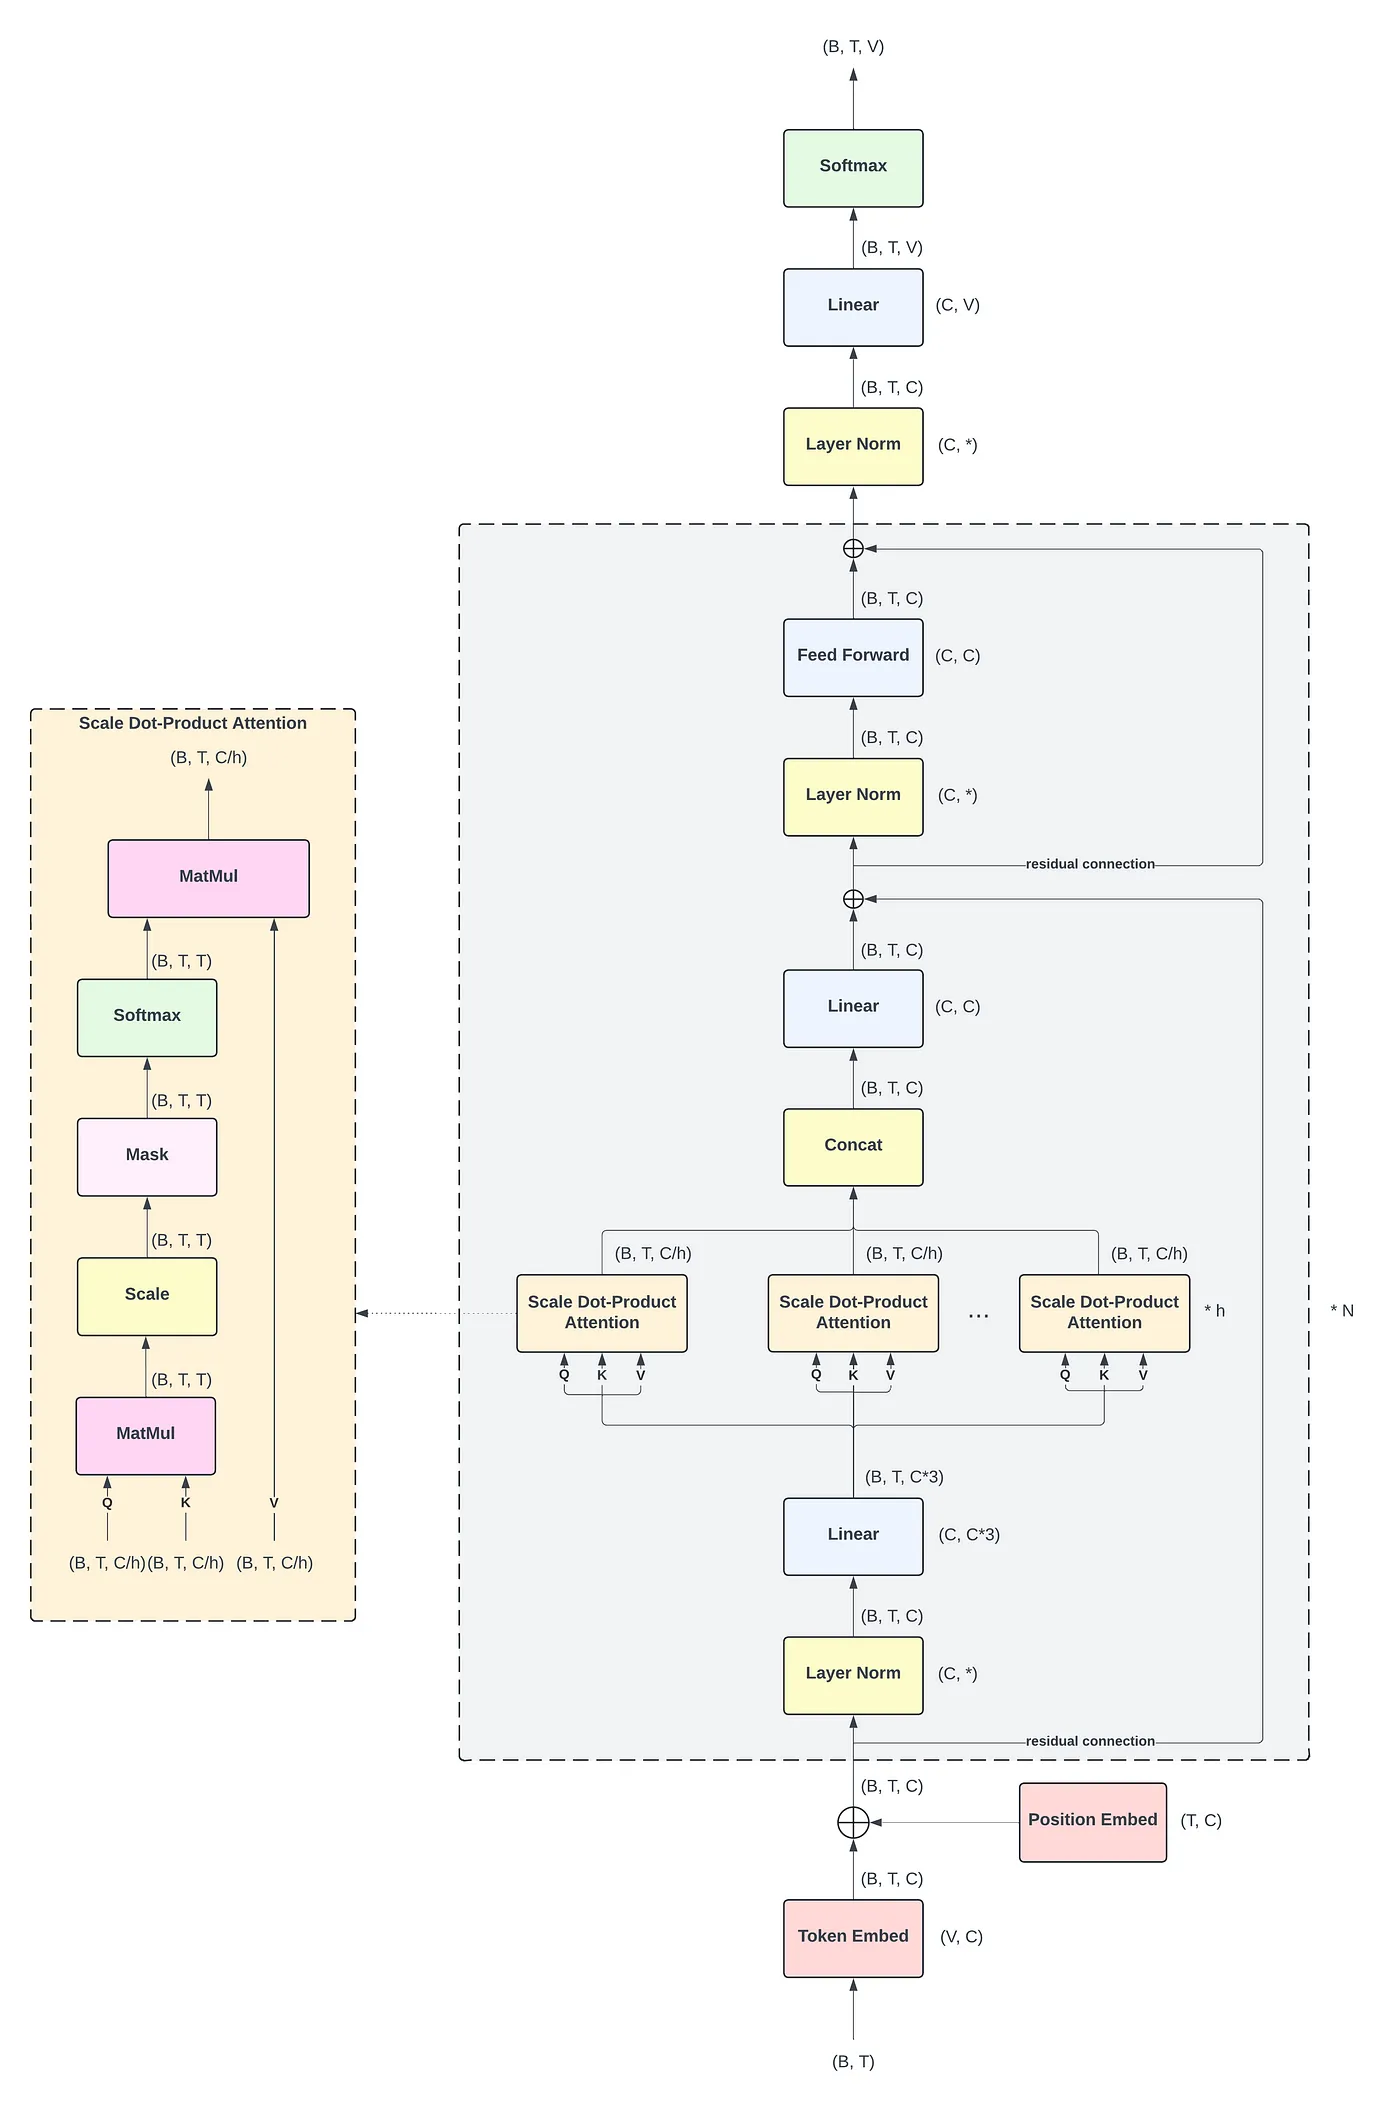

### 训练时的显卡占用
